In [ ]:
from google.colab import drive
import os
import tarfile

try:
    drive.flush_and_unmount()
    print('Drive unmounted.')
except Exception as e:
    pass

drive.mount('/content/drive', force_remount=True)

dataset_tar_path = '/content/drive/MyDrive/DLPMid02/VOCtrainval_14-Jul-2008.tar'
extract_path = '/content/'

if not os.path.exists(os.path.join(extract_path, 'VOCdevkit')):
    print("Extracting dataset...")
    with tarfile.open(dataset_tar_path, 'r') as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

Drive unmounted.
Mounted at /content/drive
Dataset already extracted.


In [ ]:
!pip install torchvision matplotlib scikit-learn --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.models.segmentation import fcn_resnet50
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.7 MB/s eta 0:00:00


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
NUM_CLASSES = 21
IMAGE_SIZE = (256, 256)
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4

In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

# For masks, do not normalize or convert to float
target_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor()
])

In [ ]:
# Load Dataset
train_dataset = VOCSegmentation(
    root="./", year='2008', image_set='train', download=True,
    transform=transform, target_transform=target_transform
)
val_dataset = VOCSegmentation(
    root="./", year='2008', image_set='val',
    transform=transform, target_transform=target_transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

100%|██████████| 577M/577M [00:29<00:00, 19.6MB/s]


In [ ]:
# Model Definition
class FCNSegmenter(nn.Module):
    def __init__(self, num_classes):
        super(FCNSegmenter, self).__init__()
        self.model = fcn_resnet50(weights="DEFAULT")
        self.model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        return self.model(x)['out']

model = FCNSegmenter(NUM_CLASSES).to(DEVICE)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:02<00:00, 49.6MB/s]


In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)  # Ignore unlabeled pixels
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.squeeze(1).long().to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)

        # Ensure output and mask have same size
        if outputs.shape[-2:] != masks.shape[-2:]:
            outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/30, Loss: 1.6726
Epoch 2/30, Loss: 0.8718
Epoch 3/30, Loss: 0.5541
Epoch 4/30, Loss: 0.3893
Epoch 5/30, Loss: 0.2861
Epoch 6/30, Loss: 0.2404
Epoch 7/30, Loss: 0.2077
Epoch 8/30, Loss: 0.1671
Epoch 9/30, Loss: 0.1483
Epoch 10/30, Loss: 0.1211
Epoch 11/30, Loss: 0.0950
Epoch 12/30, Loss: 0.0820
Epoch 13/30, Loss: 0.1018
Epoch 14/30, Loss: 0.1070
Epoch 15/30, Loss: 0.1265
Epoch 16/30, Loss: 0.0990
Epoch 17/30, Loss: 0.0731
Epoch 18/30, Loss: 0.0855
Epoch 19/30, Loss: 0.0630
Epoch 20/30, Loss: 0.0978
Epoch 21/30, Loss: 0.0733
Epoch 22/30, Loss: 0.0751
Epoch 23/30, Loss: 0.1014
Epoch 24/30, Loss: 0.0886
Epoch 25/30, Loss: 0.0527
Epoch 26/30, Loss: 0.0673
Epoch 27/30, Loss: 0.0483
Epoch 28/30, Loss: 0.0308
Epoch 29/30, Loss: 0.0272
Epoch 30/30, Loss: 0.0244


Accuracy: 0.8811503183007393
Precision: 0.739098962170157
Recall: 0.5968609586827806
F1 Score: 0.6375529678205991


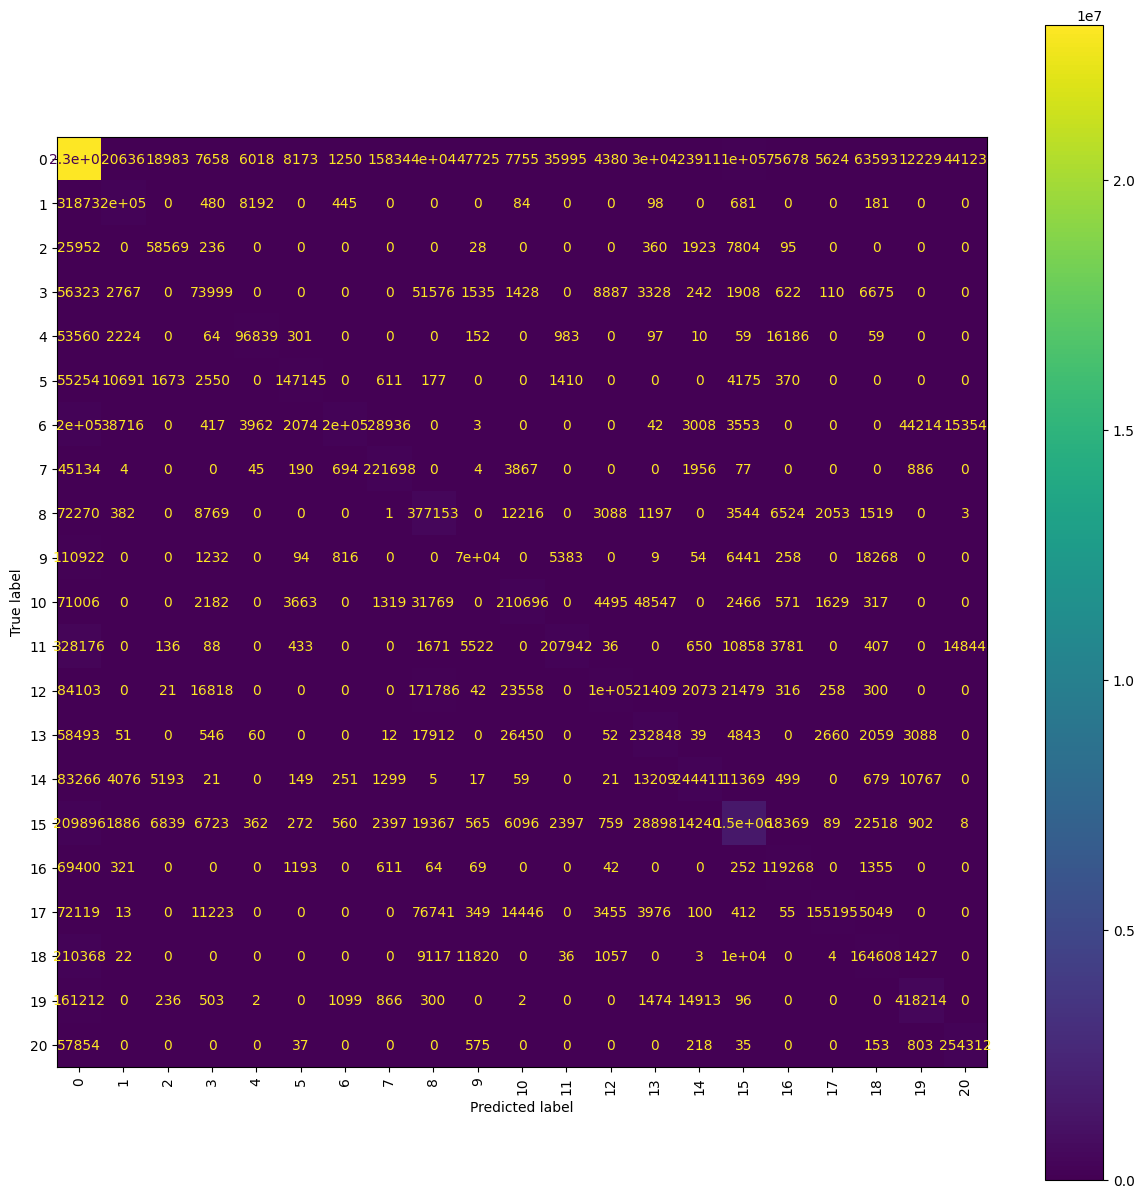

In [ ]:
# Evaluation Metrics
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(DEVICE)
        masks = masks.squeeze(1).cpu().numpy().flatten()

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy().flatten()

        y_true.extend(masks)
        y_pred.extend(preds)

# Remove background class from metric calculations (class 0)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
valid = y_true != 255
y_true = y_true[valid]
y_pred = y_pred[valid]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro', zero_division=0))
print("Recall:", recall_score(y_true, y_pred, average='macro', zero_division=0))
print("F1 Score:", f1_score(y_true, y_pred, average='macro', zero_division=0))

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, xticks_rotation='vertical')
#disp.ax_.set_xticklabels(disp.display_labels, rotation=45, ha='right') # rotate x-axis labels if needed

plt.show()

In [ ]:
# mIoU calculation
def compute_iou(y_true, y_pred, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = y_pred == cls
        target_inds = y_true == cls
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

miou = compute_iou(y_true, y_pred, NUM_CLASSES)
print("Mean IoU:", miou)

Mean IoU: 0.48714180405658614


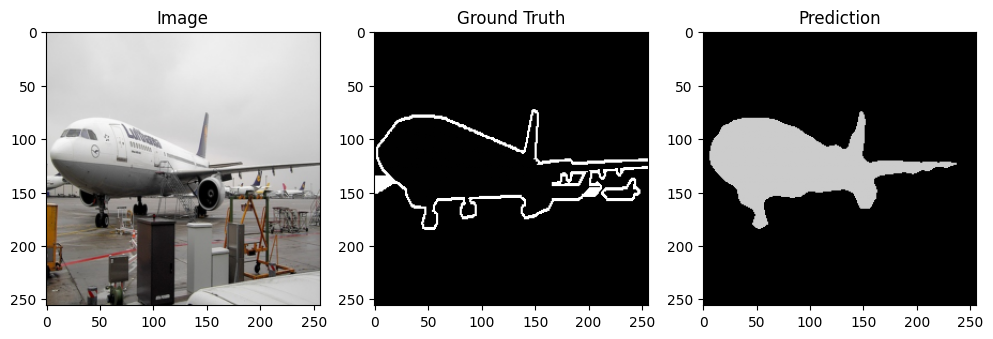

In [ ]:
# Sample Prediction Visualization
sample_img, sample_mask = val_dataset[0]
sample_img = sample_img.unsqueeze(0).to(DEVICE)
model.eval()
with torch.no_grad():
    pred = model(sample_img)
    pred = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(transforms.ToPILImage()(sample_img.squeeze().cpu()))
plt.title('Image')
plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze(), cmap='gray')
plt.title('Ground Truth')
plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='nipy_spectral')
plt.title('Prediction')
plt.show()